In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline  # if you are running this code in Jupyter notebook

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from skimage import data, transform, util
from sklearn.linear_model import LinearRegression

In [2]:
def imshow(*args):
    img_len = len(args)
    fig, axes = plt.subplots(1, img_len, figsize=(16, 8))
    
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    for ax, img in zip(axes, args):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    plt.show()

## Преобразование первых фреймов

In [338]:
for i in range(1, 6):
    filename = f'video-{i}'
    vidcap = cv2.VideoCapture(f'data/{filename}.mov')
    success, image = vidcap.read()
    cv2.imwrite(f"data/zero-frames/{filename}.png", image)
#     while success:
#         cv2.imwrite(f"data/zero-frames/{filename}.png", image)
#         success, image = vidcap.read()
#         print('Read a new frame: ', success)
#         break

## Поиск вертикальных линий по маске

In [8]:
threshold = 100

def interp(line, min_p, max_p, border=None):
    m = LinearRegression().fit(line[:, 0].reshape((line.shape[0], 1)), line[:, 1])
    if border is None or abs(m.coef_[0]) < border:  # 0.2 по умолчанию для вертикальных линий
        rows = np.arange(min_p, max_p)
        cols = m.predict(rows.reshape((rows.shape[0], 1)))
        
        return np.vstack((rows, cols)).T.astype('int32')
    
    return None

def approximate_lines(lines):
    lines_out = []
    for line_info in lines:
        if len(line_info['line']) < 5:
            continue

        line = np.array(line_info['line'])
        line = interp(line, min_p=1, max_p=line[:, 0].max(), border=0.2) 
        
        if line is not None:
            lines_out.append(line)

    return lines_out

def add_points_to_lines(lines, points: list, row, shift=1):
    for p in points:
        lines_filtered = list(filter(lambda l: l['border'][0] <= p <= l['border'][1], lines))

        if not lines_filtered:
            lines.append({'border': (p - shift, p + shift), 'line': [(row, p)]})
        else:
            if len(lines_filtered) > 1:  # дошли до дуги
                lines_filtered = sorted(lines_filtered, key=lambda l: -len(l['line']))
            
            line_info = lines_filtered[0]
            if line_info['line'][-1][0] - row < 2:
                line_info['line'].append((row, p))

                border = line_info['border']
                line_info['border'] = (min(p - shift, border[0]), max(p + shift, border[1]))  # обновить границы
    
    return lines

def lines_get_splits(array, threshold=100, i=None):
    indices = np.where(array > threshold)[0]
    
    if indices.shape[0] == 1:
        return indices

    elif indices.shape[0] > 1:
        diff, splits = np.diff(indices), []
        
        if (diff > 5).any():
            split_indices = np.where(diff > 5)[0] + 1
            splits = np.split(indices, split_indices)
        else:
            splits = [indices]

        splits = list(map(lambda v: int(v.mean()), splits))
        
        return splits

    return None

def find_vertical_lines(img_source_mask):
    green_mask = (img_source_mask[:, :, 1] > 240) & (img_source_mask[:, :, 0] < 10)
    green_mask = green_mask.astype('uint8') * 255
    
    lines = []  # (border [left, right], line)

    for i, row in enumerate(range(green_mask.shape[0] - 1, 0, -1)):
        img_row = green_mask[row, :]
        
        splits = lines_get_splits(img_row, threshold=threshold)
        if splits is not None:
            lines = add_points_to_lines(lines, splits, row)

    lines = approximate_lines(lines)  # list(np.array([row, col]))
    return sorted(lines, key=lambda l: l[0][1])

lines_v = find_vertical_lines(img_source_mask)
len(lines_v)

18

In [9]:
lines_get_splits(np.array([0, 255, 0, 0, 0, 0, 0, 0, 255, 0]))

[1, 8]

## Найти горизонтальные линии для левого и правого изображения (синий)

In [10]:
def add_h_points_to_lines(lines, points: list, col, shift=1):
    """
    """
    for row in points:
        lines_filtered = list(filter(lambda l: l[-1][0] - shift <= row <= l[-1][0] + shift, lines))

        if not lines_filtered:
            lines.append([(row, col)])
        else:
            if len(lines_filtered) > 1:  # Линии на одних и тех же строках
                # Фильтруем, чтобы первая запись была правее всего
                lines_filtered = sorted(lines_filtered, key=lambda l: -l[-1][1])

            line = lines_filtered[0]
            
#             if col == 1373:
#                 print(lines_filtered, col - line[-1][1])
#                 return None
            if col - line[-1][1] < 2:
                line.append((row, col))
            else:
                lines.append([(row, col)])
    
    return lines

def find_horisontal_lines(img_source_mask, config: dict, color=(0, 0, 255)):
    blue_mask = (img_source_mask[:, :, 0] > 240) & (img_source_mask[:, :, 1] < 30)  # blue lines
    blue_mask = blue_mask.astype('uint8') * 255
#     imshow(blue_mask)

    lines = []  # (border [left, right], line)

    for i, col in enumerate(range(0, blue_mask.shape[1])):
        img_col = blue_mask[:, col]
        
        splits = lines_get_splits(img_col, threshold=threshold, i=col)  # returns rows
        
        if splits is not None:
            lines = add_h_points_to_lines(lines, splits, col=col)
            if lines is None:
                break

    assert len(lines) in {2, 4}, f'Найдено неправильное кол-во {len(lines)} горизонтальных линий, с цветом маски: "blue"'
    res = {'left': None, 'right': None}
    for side in ['left', 'right']:
        i = 0 if side == 'left' or not config['left'] else 2
        if config[side]:
            index_top = i + (0 if lines[i][0][0] < lines[i + 1][0][0] else 1)
            res[side] = (np.array(lines[index_top]), np.array(lines[1 - index_top]))

    return res
            
lines_h = find_horisontal_lines(img_source_mask, config=images_config[index])
f'left found: {lines_h["left"] is not None}, right found: {lines_h["right"] is not None}'

'left found: True, right found: True'

## Поиск кривых (выделены зеленым цветом)

In [11]:
def add_curce_points_to_curves(curves, points: list, col, shift=1):
#     if col == 489: print(points, col)
    for row in points:
        curves_filtered = list(filter(lambda l: l[-1][0] -2 <= row <= l[-1][0] + 2, curves))

        if not curves_filtered:
            curves.append([(row, col)])
        else:
            if len(curves_filtered) > 1:  # Линии на одних и тех же строках
                raise Exception('...')
            
            curve = curves_filtered[0]
            if curve[-1][1] - col < 2:
                curve.append((row, col))

    curves_out = []
    for c in curves:
        right_point = c[-1]  # столбец последней (наиправейшей) точки
        if col - right_point[1] < 5 or len(c) > 5:
            curves_out.append(c)
#         elif col > 570:
#             print('remove_curve', col, c)
    
    return curves_out

def find_horisontal_curces(img_source_mask, color='green'):
    green_mask = (img_source_mask[:, :, 1] > 240) & (img_source_mask[:, :, 0] < 20)
    green_mask = green_mask.astype('uint8') * 255

    curves = []  # (border [left, right], line)

    for i, col in enumerate(range(0, green_mask.shape[1])):
        img_col = green_mask[:, col]
        
        splits = lines_get_splits(img_col, threshold=threshold, i=col)  # returns rows
#         if col == 489: print('splits:', splits)
        if splits is not None:
            curves = add_curce_points_to_curves(curves, splits, col=col)
    
    curves = add_curce_points_to_curves(curves, points=[], col=green_mask.shape[1] - 1)

    assert len(curves) == 2, f'Найдено неправильное кол-во {len(curves)} горизонтальных кривых, с цветом маски: "{color}"'
    index_top = 0 if curves[0][0][0] < curves[1][0][0] else 1
    return {'top': np.array(curves[index_top]), 'bottom': np.array(curves[1 - index_top])}
            
curves = find_horisontal_curces(img_source_mask)

In [12]:
rng = np.arange(1080).reshape((1, 1080))
np.vstack((img_source_mask[:, 489, 0], img_source_mask[:, 489, 1], img_source_mask[:, 489, 2], rng)).T.tolist()

[[234, 219, 206, 0],
 [234, 219, 206, 1],
 [233, 218, 205, 2],
 [233, 218, 205, 3],
 [232, 217, 204, 4],
 [232, 217, 204, 5],
 [231, 216, 203, 6],
 [231, 216, 203, 7],
 [231, 216, 203, 8],
 [230, 215, 202, 9],
 [230, 215, 202, 10],
 [230, 215, 202, 11],
 [230, 215, 202, 12],
 [229, 214, 201, 13],
 [229, 214, 201, 14],
 [229, 214, 201, 15],
 [229, 214, 201, 16],
 [229, 214, 201, 17],
 [229, 214, 201, 18],
 [229, 214, 201, 19],
 [229, 214, 201, 20],
 [229, 214, 201, 21],
 [229, 214, 201, 22],
 [229, 214, 201, 23],
 [227, 212, 199, 24],
 [227, 212, 199, 25],
 [226, 211, 198, 26],
 [226, 211, 198, 27],
 [226, 211, 198, 28],
 [226, 211, 198, 29],
 [226, 211, 198, 30],
 [226, 211, 198, 31],
 [228, 211, 198, 32],
 [228, 211, 198, 33],
 [227, 210, 197, 34],
 [227, 210, 197, 35],
 [227, 210, 197, 36],
 [226, 209, 196, 37],
 [225, 208, 195, 38],
 [225, 208, 195, 39],
 [225, 208, 195, 40],
 [224, 207, 194, 41],
 [222, 205, 192, 42],
 [222, 205, 192, 43],
 [222, 205, 192, 44],
 [221, 204, 191, 45]

In [13]:
def insert_boxes(img, boxes):
#     tmp = np.ones(img.shape).astype('uint8') * 255
    tmp = img.copy()
    for side in ['left', 'middle', 'right']:
        if side not in boxes or boxes[side] is None:
            continue
        
        for el in boxes[side]:
            if isinstance(el, str):
                line = boxes[side][el]
                for point in line:
                    tmp[int(point[0]), int(point[1])] = 0
            else:
                for direction in ['top', 'right', 'left', 'bottom']:
                    line = el[direction]
                    for point in line:
                        tmp[int(point[0]), int(point[1])] = 0
    imshow(tmp)

In [14]:
def intersect2d(l1, l2, name=None):
    l1_set = set(map(tuple, l1))
    l2_set = set(map(tuple, l2))
    
    intersect = l1_set & l2_set
    if len(intersect) > 1:
        intersect = sorted(intersect, key=lambda v: v[1])[-1:]

    if len(intersect) == 1:
        p = list(intersect)[0]
        
        l1_index = np.where((l1[:, 0] == p[0]) & (l1[:, 1] == p[1]))[0]
        l2_index = np.where((l2[:, 0] == p[0]) & (l2[:, 1] == p[1]))[0]
        
        return p, l1_index[0], l2_index[0]
    else:
        raise Exception(f'The intersect is not single: {len(intersect)} ({intersect})')

def create_left_box(lines_v, lines_h):
    print('create_left_box')
    line_vl, line_vr = lines_v[0], lines_v[1]
    left, right = line_vl[:, 1].min(), line_vr[:, 1].max()
    
    line_top = interp(lines_h[0][:, [1, 0]], min_p=left, max_p=right + 1)[:, [1, 0]]
    line_bottom = interp(lines_h[1][:, [1, 0]], min_p=left, max_p=right + 1)[:, [1, 0]]
    
    return create_middle_boxes(lines_v, {'top': line_top, 'bottom': line_bottom})[0]

def create_right_box(lines_v, lines_h):
    if len(lines_v) == 0:
        return []
    
    if len(lines_v) == 1:
        rows = np.arange(lines_h[0][-1, 0], lines_h[1][-1, 0] + 1)
        cols = np.array([max(lines_h[0][:, 1].max(), lines_h[1][:, 1].max())] * rows.size)
        
        lines_v.append(np.vstack((rows, cols)).T)

    return create_left_box(lines_v, lines_h)

    line_left, line_right = lines_v[0], None if len(lines_v) == 1 else lines_v[0]

def create_middle_boxes(lines_v, curves):
    print(f'Find middle boxes using {len(lines_v)} lines')
    boxes = []
    for i in range(0, len(lines_v), 2):
        print(f'Find middle box: {i}, lines: {i}, {i + 1}')
        l1, l2 = lines_v[i], lines_v[i + 1]
        
        p, l_lt_index, l_tl_index = intersect2d(l1, curves['top'], name='left-top')
        p, l_rt_index, l_tr_index = intersect2d(l2, curves['top'], name='right-top')
        
        p, l_lb_index, l_bl_index = intersect2d(l1, curves['bottom'], name='left-bottom')
        p, l_rb_index, l_br_index = intersect2d(l2, curves['bottom'], name='right-bottom')

        box = {
            'top': curves['top'][l_tl_index: l_tr_index + 1],  # top
            'right': l2[l_rt_index: l_rb_index + 1],  # right
            'bottom': curves['bottom'][l_bl_index: l_br_index + 1],  # bottom
            'left': l1[l_lt_index: l_lb_index + 1],  # left
        }
        
        boxes.append(box)

    return boxes

def create_boxes(img_source_mask, config: dict):
    curves = find_horisontal_curces(img_source_mask)
    lines_h = find_horisontal_lines(img_source_mask, config)
    lines_v = find_vertical_lines(img_source_mask)
    
    left_box = create_left_box(lines_v[:2], lines_h['left']) if config['left'] else None

    middle_index = 2 if config['left'] else 0
    middle_index_end = len(lines_v) - (config['right'] * 2 - config['right-path'])  # 7 центральных рамок
    print(middle_index, middle_index_end, len(lines_v))
    middle_boxes = create_middle_boxes(lines_v[middle_index: middle_index_end], curves)
    
    right_index = 1 if config['right-path'] else 2
    right_box = create_right_box(lines_v[-right_index:], lines_h['right']) if config['right'] else None

    return {'left': left_box, 'middle': middle_boxes, 'right': right_box}

boxes = create_boxes(img_source_mask, config=images_config[index])
# boxes

create_left_box
Find middle boxes using 2 lines
Find middle box: 0, lines: 0, 1
2 16 18
Find middle boxes using 14 lines
Find middle box: 0, lines: 0, 1
Find middle box: 2, lines: 2, 3
Find middle box: 4, lines: 4, 5
Find middle box: 6, lines: 6, 7
Find middle box: 8, lines: 8, 9
Find middle box: 10, lines: 10, 11
Find middle box: 12, lines: 12, 13
create_left_box
Find middle boxes using 2 lines
Find middle box: 0, lines: 0, 1


## Чтение маски

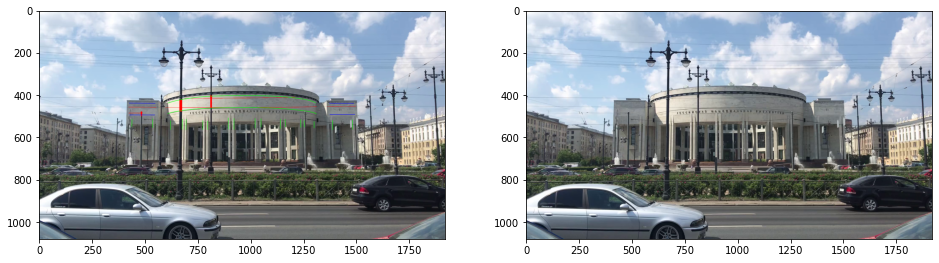

In [4]:
index = 1
img_source_mask = cv2.imread(f'data/mask/video-{index}.png')
img_source = cv2.imread(f'data/zero-frames/video-{index}.png')

imshow(img_source_mask, img_source)

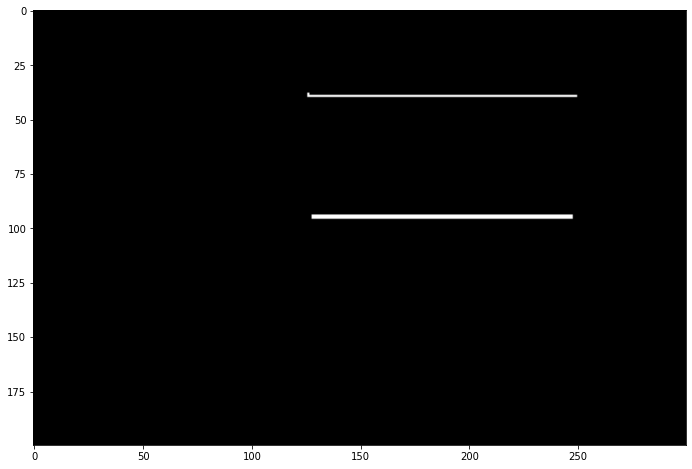

In [15]:
mask_blue = (img_source_mask[400:600, 300:600] == [255, 0, 0]).mean(axis=2).astype('uint8') * 255
imshow(mask_blue)

## Преобразования Хафа

4
[[1073  140 1188  140]]
[[128 194 247 194]]
[[126 139 249 139]]
[[1075  192 1194  192]]


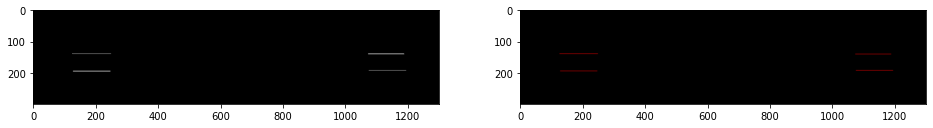

In [141]:
mask_blue = (img_source_mask[300:600, 300:1600] == [255, 0, 0]).mean(axis=2).astype('uint8') * 255
mask_blue_out = cv2.cvtColor(mask_blue.copy() * 0, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLinesP(mask_blue, rho=5.0, theta=np.pi / 70, threshold=100)
print(len(lines))
a,b,c = lines.shape
for line in lines:
    print(line)
    cv2.line(mask_blue_out, (line[0][0], line[0][1]), (line[0][2], line[0][3]), (0, 0, 255), 1, cv2.LINE_AA)
imshow(mask_blue, mask_blue_out)

## findContours

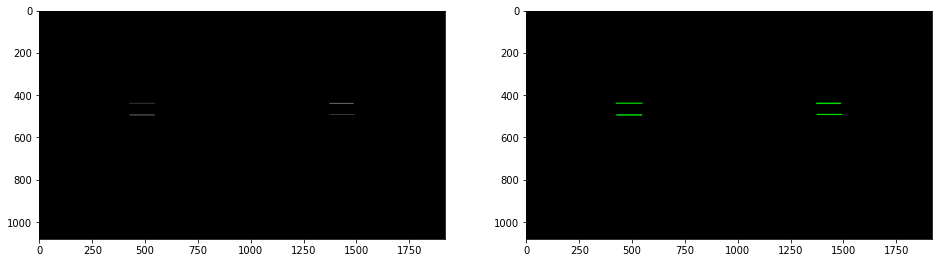

In [177]:
mask_blue = (img_source_mask == [255, 0, 0]).mean(axis=2).astype('uint8') * 255
mask_blue_out = cv2.cvtColor(mask_blue.copy() * 0, cv2.COLOR_GRAY2BGR)

contours, _ = cv2.findContours(mask_blue, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_out = cv2.drawContours(mask_blue_out, contours, -1, (0, 255, 0), 3)
imshow(mask_blue, img_out)

create_left_box
Find middle boxes using 2 lines
Find middle box: 0, lines: 0, 1
2 16 18
Find middle boxes using 14 lines
Find middle box: 0, lines: 0, 1
Find middle box: 2, lines: 2, 3
Find middle box: 4, lines: 4, 5
Find middle box: 6, lines: 6, 7
Find middle box: 8, lines: 8, 9
Find middle box: 10, lines: 10, 11
Find middle box: 12, lines: 12, 13
create_left_box
Find middle boxes using 2 lines
Find middle box: 0, lines: 0, 1


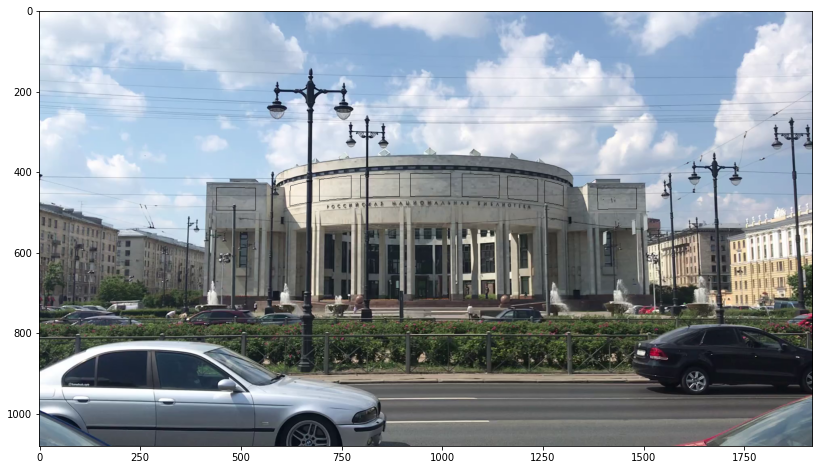

In [16]:
boxes = create_boxes(img_source_mask, config=images_config[index])
insert_boxes(img_source, boxes)

## Вставка изображения в библиотеку

In [17]:
def calc_mask(pic, red_mask):
    mask = np.ones((pic.shape[0], pic.shape[1])).astype(bool)

    mask[red_mask] = False
    mask[(pic == [0, 0, 0]).all(axis=2)] = False
    
    return mask

def insert_pic(img, pic, shift):
    red_mask = (img_source_mask[:, :, 2] > 240) & (img_source_mask[:, :, 0] < 10)
    red_mask_path = red_mask[shift[0]: shift[0] + pic.shape[0], shift[1]: shift[1] + pic.shape[1]]
    mask = ~calc_mask(pic, red_mask_path)
    
    img_path = img[shift[0]: shift[0] + pic.shape[0], shift[1]: shift[1] + pic.shape[1], :]
    pic[mask] = img_path[mask]
    
    delta = 5
    pic[:delta, :] = ((pic[:delta, :].astype('int32') + img_path[:delta, :].astype('int32')) / 2).astype('uint8')
    pic[-delta:, :] = ((pic[-delta:, :].astype('int32') + img_path[-delta:, :].astype('int32')) / 2).astype('uint8')
    
    img[shift[0]: shift[0] + pic.shape[0], shift[1]: shift[1] + pic.shape[1], :] = pic
    
    return img

## Функции преобразования изображений

In [18]:
def insert_right_pic(img, pic, box, config):
    pic_h, pic_w, _ = pic.shape
    box_h, box_w = box['left'][-1, 0] - box['left'][0, 0], box['bottom'][-1, 1] - box['bottom'][0, 1]
    
    if box_w < box_h:
        pic = pic[:, :int(pic_w * (box_w / box_h))]

    return insert_left_pic(img, pic, box, config=config, to_resize=True, linear=True)

In [19]:
def calc_mask(pic, red_mask):
    mask = np.ones((pic.shape[0], pic.shape[1])).astype(bool)

    mask[red_mask] = False
    mask[(pic == [0, 0, 0]).all(axis=2)] = False
    
    return mask

def smooth_line(img_path, pic, line: np.ndarray, step: np.ndarray, coefs_save: list):
    h, w, _ = pic.shape
    
    line = line.copy()
    for coef in coefs_save:
        line_next = line[(line[:, 0] < h) & (line[:, 1] < w)]
        x, y = line_next[:, 0], line_next[:, 1]
        pic[x, y] = (pic[x, y] * (1 - coef)) + (img_path[x, y] * coef)
        
        line += step
    
    return pic.astype('uint8')
    

def insert_pic(img, pic, shift_outside, box, shift_inside: int, config: dict, img_index=None):
    h, w, _ = pic.shape
    shift = shift_outside + np.array([0, shift_inside])

    red_mask = (img_source_mask[:, :, 2] > 240) & (img_source_mask[:, :, 0] < 10)
    red_mask_path = red_mask[shift[0]: shift[0] + h, shift[1]: shift[1] + w]
    mask = ~calc_mask(pic, red_mask_path)
    
    img_path = img[shift[0]: shift[0] + h, shift[1]: shift[1] + w, :]

    green_threshold = config.get('green_threshold')
    if img_index in config.get('green_filter', []) and green_threshold is not None:
        mask[img_path.mean(axis=2) < green_threshold] = True
    
    pic[mask] = img_path[mask]
    
    coef_big = np.ones((h + 2, w + 2)) * 2
    coef = np.ones((h, w)) * 2
    coef[~mask] = 0
    coef_big[1:-1, 1:-1] = coef
    
    for i in range(10):
        coef_big[1:-1, 1:-1] = util.view_as_windows(coef_big, (3, 3), 1).mean(axis=(2, 3))

    coef_big = np.clip(coef_big, 0, 1).reshape((h + 2, w + 2, 1))
    coef = coef_big[1:-1, 1:-1]
    
    pic = ((pic * (1 - coef)) + (img_path * coef)).astype('uint8')
    img[shift[0]: shift[0] + pic.shape[0], shift[1]: shift[1] + pic.shape[1], :] = pic
    
    return img

In [20]:
def to_resize_pic(pic, box):
    pic_h, pic_w, _ = pic.shape
    box_h, box_w = box['left'][-1, 0] - box['left'][0, 0], box['bottom'][-1, 1] - box['bottom'][0, 1]
    
    delta = max(pic_h / box_h, pic_w / box_w)
    pic_resized = cv2.resize(pic, (int(pic_w / delta), int(pic_h / delta)))
    
    return pic_resized

def matrix_for_perspective_transform(pic, box: dict, shift: tuple, delta = 60):
    h, w, _ = pic.shape
    width_max = box['top'][-1, 1] - box['top'][0, 1]
    shift_left = int((width_max - w) / 2)
    
    src = np.array([[0, 0], [0, w], [h, w], [h, 0]], dtype='float32')
    src += delta
    
    top, bottom = box['top'] - shift, box['bottom'] - shift
    dst = np.array([
        [top[shift_left, 0], top[shift_left:, 1].min()],
        [top[-shift_left, 0], top[:-shift_left, 1].max()],
        [bottom[-shift_left, 0], bottom[:-shift_left, 1].max()],
        [bottom[shift_left, 0], bottom[shift_left:, 1].min()],
    ], dtype='float32')
    img_width_new = dst[1, 1] - dst[0, 1]
    dst += delta
    
    pic_in = np.zeros((h + delta * 2, w + delta * 2, 3), dtype='uint8')
    pic_in[delta: h + delta, delta: w + delta] = pic

    M = cv2.getPerspectiveTransform(src[:, [1, 0]], dst[:, [1, 0]])
    return M, pic_in, img_width_new
    
    
def affine_transform(pic, curve_top, curve_bottom):
    height, width, _ = pic.shape
    width_max = max(curve_top.shape[0], curve_bottom.shape[0])
    
    if curve_top.shape[0] < width_max:
        curve_top = np.vstack((curve_top, curve_top[-(width_max - curve_top.shape[0]):]))
    
    if curve_bottom.shape[0] < width_max:
        curve_bottom = np.vstack((curve_bottom, curve_bottom[-(width_max - curve_bottom.shape[0]):]))

    start_point = int((width_max - width) / 2)
    end_point = start_point + width 
    
    cols = np.repeat(np.arange(width), 2)
    
    src_rows = np.vstack((np.zeros(width), np.full(width, fill_value=height)))
    src = np.vstack((src_rows.T.flat, cols)).T  # col, row

    dst_cols = np.vstack((curve_top[start_point: end_point, 1], curve_bottom[start_point: end_point, 1]))
    dst_rows = np.vstack((curve_top[start_point: end_point, 0], curve_bottom[start_point: end_point, 0]))
    dst = np.vstack((dst_rows.T.flat, dst_cols.T.flat)).T
    
    img_width_new = curve_top[-1, 1] - curve_top[0, 1]
    
    pic_copy = np.zeros((height, width, 3), dtype='uint8')
    pic_copy[:] = pic
    
    tform = transform.PiecewiseAffineTransform()
    tform.estimate(src[:, [1, 0]], dst[:, [1, 0]])
    
    out_h, out_w, _ = pic.shape
    out = transform.warp(pic_copy, tform.inverse, clip=False, mode='constant', cval=0,
                         output_shape=(out_h + 100, out_w + 100))

    return util.img_as_ubyte(out), img_width_new

def insert_left_pic(img, pic, box, config, to_resize=True, linear=True, img_index=None):
    pic_h, pic_w, _ = pic.shape
    box_h, box_w = box['left'][-1, 0] - box['left'][0, 0], box['bottom'][-1, 1] - box['bottom'][0, 1]

    pic_resized = to_resize_pic(pic, box) if to_resize else pic

    shift = [box['left'][:, 0].min(), box['left'][:, 1].min()]

    if linear:
        M, pic_in, img_width_new = matrix_for_perspective_transform(pic_resized, box=box, shift=shift)
        warped = cv2.warpPerspective(pic_in, M, (pic_in.shape[1] + 100, pic_in.shape[0] + 200))

    else:
        top, left = box['top'][:, 0].min(), box['left'][:, 1].min()
        pic_curve_top = box['top'] - np.array([top, left])
        pic_curve_bottom = box['bottom'] - np.array([top, left])

        warped, img_width_new = affine_transform(pic_resized, pic_curve_top, pic_curve_bottom)

    warped = warped[:, ~(warped == [0, 0, 0]).all(axis=2).all(axis=0)]
    warped = warped[~(warped == [0, 0, 0]).all(axis=2).all(axis=1), :]
    
    shift_inside = int((box_w - pic_resized.shape[1]) / 2)
    shift = [
        min(box['left'][:, 0].min(), box['right'][:, 0].min()),
        box['left'][:, 1].min()# + shift_inside
    ]

    img = insert_pic(img, warped, shift, box, shift_inside, config, img_index=img_index)
    
    return img

## Тестировочный запуск преобразований

## Тестировочная вставка

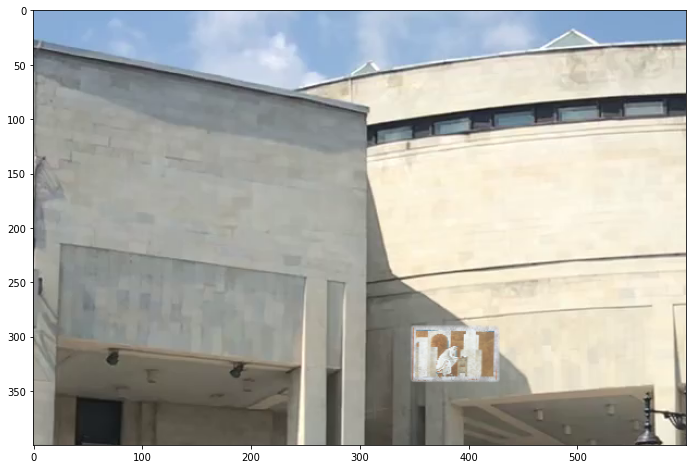

In [45]:
img_work = img_source.copy()

config = images_config[index]
pic = input_images[0]  #
box = boxes['left']  # boxes['middle'][1]

img_work = insert_left_pic(img_work, pic, config=config, box=box, linear=False, img_index=0)
# img_work = insert_right_pic(img_work, input_images[i], box=box)#, linear=True)
# insert_boxes(img_work[:300, :800], {'middle': boxes['middle'][i: i + 1]})
imshow(img_work[150:550, 100:700])

## Чтение маски

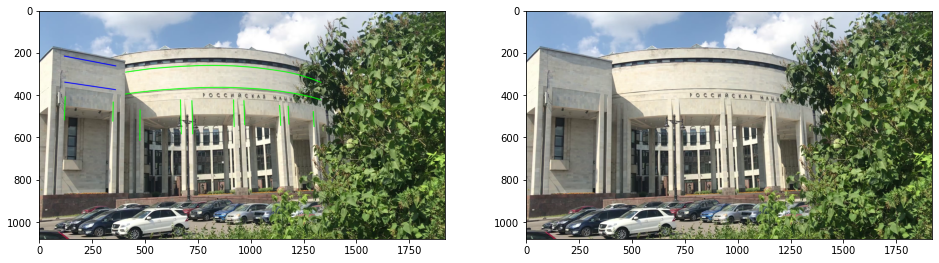

In [36]:
index = 3
img_source_mask = cv2.imread(f'data/mask/video-{index}.png')
img_source = cv2.imread(f'data/zero-frames/video-{index}.png')

imshow(img_source_mask, img_source)

## Создание конфигурации

In [38]:
images_config = {
    1: {
        'left': True,
        'right': True,
        'right-path': False,
        'dark': [.05, .001, .002, .02, .04, .08, .1, .12, .1],
        'images': [],
        'green_threshold': None,
        'green_filter': []
    },
    2: {
        'left': True,
        'right': True,
        'right-path': False,
        'dark': [.05, .001, .002, .02, .04, .08, .1, .12, .1],
        'images': [],
        'green_threshold': None,
        'green_filter': []
    },
    3: {
        'left': True,
        'right': False,
        'right-path': False,
        'dark': [.06, .01, .01, .04, .08, 0, 0, 0, 0],
        'images': [],
        'green_threshold': 160,
        'green_filter': [4]
    },
    4: {
        'left': False,
        'right': True,
        'right-path': True,
        'dark': [0, 0, .05, .1, .12, .18, .2, .22, .34],
        'images': [],
        'green_threshold': None
    },
    5: {
        'left': True,
        'right': True,
        'right-path': False,
        'dark': [.05, 0, .02, .02, .02, .01, .01, .01, .001],
        'images': [],
        'green_threshold': 160,
        'green_filter': [0]
    },
}

### Чтение входных файлов и преобразование их контрастности

In [43]:
input_images = []
for i in range(1, 10):
    img = cv2.imread(f'data/{i}.jpg')
    input_images.append(img)
    for config_id, config in images_config.items():
        dark_coef = config['dark'][i - 1]
        if dark_coef > 0:
            img = (img.astype('float32') * (1 - dark_coef)).astype('uint8')
        
        config['images'].append(img)

## Вставка изображений в первый фрейм

create_left_box
Find middle boxes using 2 lines
Find middle box: 0, lines: 0, 1
2 10 10
Find middle boxes using 8 lines
Find middle box: 0, lines: 0, 1
Find middle box: 2, lines: 2, 3
Find middle box: 4, lines: 4, 5
Find middle box: 6, lines: 6, 7


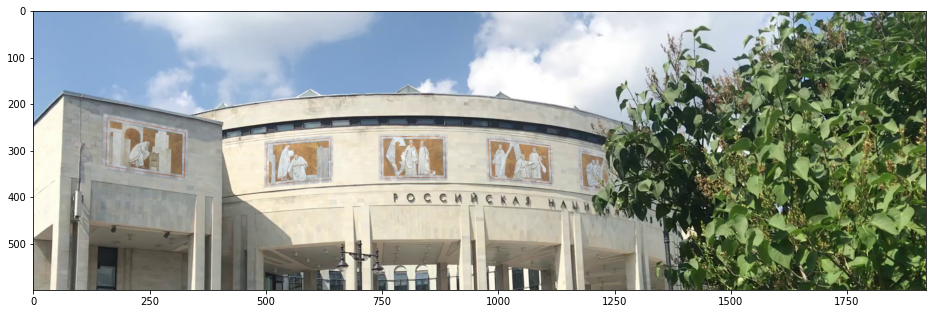

In [46]:
img_work = img_source.copy()
boxes = create_boxes(img_source_mask, config=images_config[index])

config = images_config[index]

if boxes['left'] is not None:
    img_work = insert_left_pic(img_work, config['images'][0], config=config, box=boxes['left'],
                               linear=True, img_index=0)
if boxes['right'] is not None:
    img_work = insert_right_pic(img_work, config['images'][-1], config=config, box=boxes['right'])

indices = list(filter(lambda i: config['dark'][i] > 0, range(1, 8)))
images = list(map(lambda v: config['images'][v], indices))
for i, pic, box in zip(indices, images, boxes['middle']):
    img_work = insert_left_pic(img_work, pic, box=box, config=config, linear=False, img_index=i)

if config['right-path']:
    img_work = img_work[:, :-20, :]

# plt.imsave('out.png', cv2.cvtColor(img_work, cv2.COLOR_RGB2BGR))
imshow(img_work[:600, :])
# insert_boxes(img_work, boxes)

## Встроение картин в билиотеку

In [448]:
filename = f'video-{index}'
frames = []

config = images_config[index]
boxes = create_boxes(img_source_mask, config=config)

vidcap = cv2.VideoCapture(f'data/{filename}.MOV')
    
success, iteration = True, 0
while success:
    print(f'Iteration {iteration}')
    success, frame = vidcap.read()
    if not success:
        break

    try:
        height, width, layers = img.shape
        size = (width, height)

        if boxes['left'] is not None:
            frame = insert_left_pic(frame, conf['images'][0], config=config, box=boxes['left'],
                                       linear=True, img_index=0)
        if boxes['right'] is not None:
            frame = insert_right_pic(frame, conf['images'][-1], config=config, box=boxes['right'])

        indices = list(filter(lambda i: config['dark'][i] > 0, range(1, 8)))
        images = list(map(lambda v: config['images'][v], indices))
        for i, pic, box in zip(indices, images, boxes['middle']):
            frame = insert_left_pic(frame, pic, box=box, config=config, linear=False, img_index=i)
            
            
        if config['right-path']:
            frame = frame[:, :-20, :]

        frames.append(frame)
        
    except Exception as e:
        print('error', e)
        break

    iteration += 1
#     if iteration > 30: break

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
h, w, _ = frames[0].shape
out = cv2.VideoWriter(f'data/out/{filename}.mov', fourcc, 20.0, (w, h))
 
for i in range(len(frames)):
    out.write(frames[i])
out.release()

create_left_box
Find middle boxes using 2 lines
Find middle box: 0, lines: 0, 1
2 14 16
Find middle boxes using 12 lines
Find middle box: 0, lines: 0, 1
Find middle box: 2, lines: 2, 3
Find middle box: 4, lines: 4, 5
Find middle box: 6, lines: 6, 7
Find middle box: 8, lines: 8, 9
Find middle box: 10, lines: 10, 11
create_left_box
Find middle boxes using 2 lines
Find middle box: 0, lines: 0, 1
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Ite

In [115]:
# fourcc = cv2.VideoWriter_fourcc(*'h263')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
h, w, _ = frames[0].shape
out = cv2.VideoWriter(f'data/out/{filename}.mov', fourcc, 20.0, (w, h))

for i in range(len(frames)):
    out.write(frames[i])

out.release()

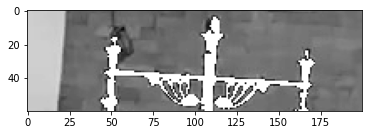

In [199]:
gray = cv2.cvtColor(img_source[350: 410, 200: 400], cv2.COLOR_BGR2GRAY)
gray[:, :][gray[:, :] < 90] = 255

plt.imshow(gray, cmap='gray')